
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BEACS module
from beacs.agents.beacs import BEACS, Configuration

# Load Metrics
from example.metrics.MazeMetrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _enhanced_effect_error

# Load Plotting Wrappers
from example.metrics.MazePlottingWrapper import \
    parse_metrics_to_df, \
    plot_performance

# Load environments
import gym
import my_mazes

# Agent - BEACS

## Common parameters

In [2]:
#Environmental Set Up
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8
SLIPPERY_PROB = 0.
MAZE = "MazeE1-v0"

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 5000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
EPSILON = 0.8
BETA_ALP = 0.05

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.00
NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

#RL Set Up
GAMMA = 0.95
BETA_RL = 0.05

#GA Set Up
CROSSOVER = 0.8
MUTATION = 0.3

#BEACS Set Up
DO_ZIP = True
ENABLE_PEP = True
LENGTH_OF_BEHAVIORAL_SEQUENCES = 2

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ □ □ □ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ □ □ □ ■ □ ■
■ □ ■ □ $ □ ■ □ ■
■ □ ■ A □ □ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ □ □ □ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of BEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    mu=MUTATION,
    chi=CROSSOVER,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 13min 33s, sys: 980 ms, total: 13min 34s
Wall time: 13min 35s


### Performance

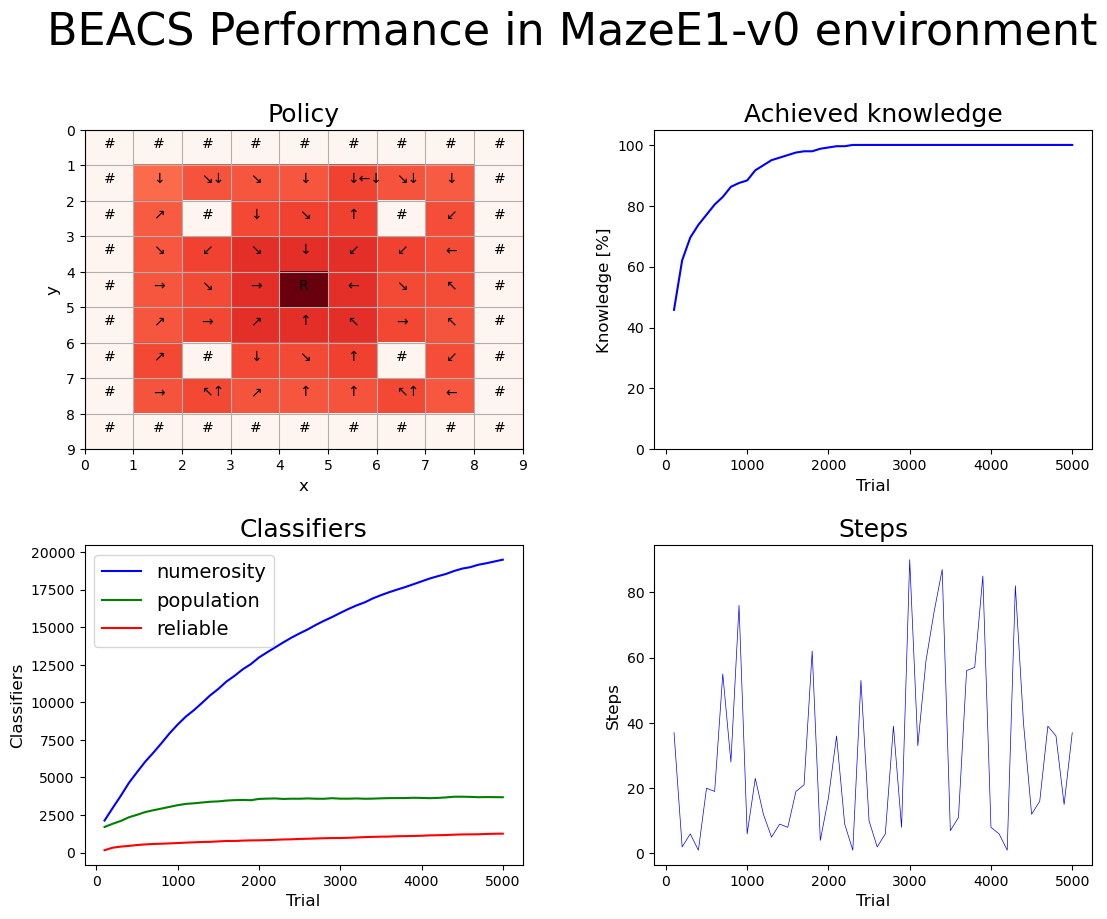

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)
print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.\n")

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%\n")

if DO_ZIP:
    agent_explore.zip_population()
    population_explore = agent_explore.get_population()

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%")

Full knowledge was achieved at trials  2300 , was stable at  2300  and the last time it was achieved at  5000
There are  1  enhanced classifer(s) that match a non-aliased states.

{'knowledge': 100.0, 'population': 3685, 'numerosity': 19497, 'reliable': 1260}
Mean reliable population specifity is  0.6326388888888889
Accumulated Error on PEP Probabilities : 0.7003193548470293 %

{'knowledge': 100.0, 'population': 933, 'numerosity': 10268, 'reliable': 771}
Mean reliable population specifity is  0.5671206225680934
Accumulated Error on PEP Probabilities : 0.7377095467823207 %


In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore]
for cl in population_explore_to_display:
    print(cl)
    print("\n")

###9#### 3 None (###0###0:#1) (empty)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 2.859e-07
exp: 884   num: 20 ee: False PAI_state: 
tga: 161965 tbseq: 162119 talp: 161980 tav: 227.0  



#######9 7 None (###0###0:#1) (empty)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 3.96e-07
exp: 866   num: 20 ee: False PAI_state: 
tga: 161978 tbseq: 160991 talp: 161978 tav: 201.5  



###0#1#0 1 None (#0###0##:#1) (empty)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.0001755
exp: 642   num: 2 ee: False PAI_state: 
tga: 162170 tbseq: 161803 talp: 162170 tav: 283.4  



#9###### 1 None (#0###0##:#1) (empty)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.0001335
exp: 645   num: 16 ee: False PAI_state: 
tga: 162170 tbseq: 161803 talp: 162170 tav: 283.4  



######9# 6 None (######0#:#1) (empty)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.0009204
exp: 575   num: 20 ee: False PAI_state: 
tga: 162133 tbseq: 162031 talp: 162133 tav: 327

#09##### 6 [3] (#90##1##:#1) (empty)
q: 0.9126 ra: 527.9  rb: 548.6  ir: 0.0    f: 491.2  err: 478.8 
exp: 34    num: 20 ee: False PAI_state: 00000000
tga: 158975 tbseq: 9612  talp: 158975 tav: 5.057e+03 



0##9##01 6 [5] (###0#11#:#1) (empty)
q: 0.9888 ra: 491.1  rb: 501.8  ir: 0.0    f: 490.9  err: 333.4 
exp: 63    num: 10 ee: False PAI_state: 10000000
tga: 159164 tbseq: 9774  talp: 159164 tav: 3.389e+03 



0#11010# 4 [7] (#00010##:#1) (empty)
q: 0.9595 ra: 452.3  rb: 569.5  ir: 0.0    f: 490.2  err: 369.2 
exp: 46    num: 9 ee: False PAI_state: 01110010
tga: 159859 tbseq: 11457 talp: 159859 tav: 3.985e+03 



01110#10 7 [5] (#0#0##0#:#1) (empty)
q: 0.9831 ra: 480.2  rb: 512.0  ir: 0.0    f: 487.7  err: 376.4 
exp: 53    num: 20 ee: False PAI_state: 11001001
tga: 161306 tbseq: 5455  talp: 161306 tav: 3.903e+03 



0#1101## 6 [5, 0] (#00##0#9:#1) (empty)
q: 0.9477 ra: 514.3  rb: 527.1  ir: 0.0    f: 487.4  err: 381.2 
exp: 22    num: 4 ee: False PAI_state: 00001000
tga: 160347 tbse


##1###11 1 None (110#100#:#1) (00100111)
q: 0.4714 ra: 803.1  rb: 807.3  ir: 0.0    f: 380.6  err: 5.458 
exp: 7     num: 1 ee: True PAI_state: 
tga: 161856 tbseq: 160804 talp: 161856 tav: 322.4  



0000#111 1 [3] (##9##000:#1) (empty)
q: 0.9251 ra: 349.7  rb: 472.8  ir: 0.0    f: 380.4  err: 469.4 
exp: 25    num: 20 ee: False PAI_state: 10000000
tga: 159389 tbseq: 10056 talp: 159389 tav: 6.076e+03 



00#00#10 7 [5] (##1##1#1:#1) (empty)
q: 0.9702 ra: 378.6  rb: 402.7  ir: 0.0    f: 379.0  err: 345.9 
exp: 51    num: 20 ee: False PAI_state: 11001001
tga: 153053 tbseq: 9151  talp: 153053 tav: 3.955e+03 



0#1#0111 1 [0, 7] (#10#####:#20, 110#100#:#18) (empty)
q: 1.0    ra: 524.5  rb: 378.7  ir: 0.0    f: 378.7  err: 331.8 
exp: 37    num: 18 ee: False PAI_state: 00001000
tga: 160590 tbseq: 37884 talp: 160590 tav: 3.511e+03 



####9### 0 [7] (11##01#1:#1) (empty)
q: 0.9528 ra: 376.2  rb: 418.8  ir: 0.0    f: 378.7  err: 371.4 
exp: 43    num: 18 ee: False PAI_state: 00000000
tga: 1

In [8]:
agent_explore.get_pai_states_memory()

[('0', '0', '0', '0', '0', '0', '0', '0'),
 ('0', '0', '0', '0', '1', '0', '0', '0'),
 ('1', '1', '0', '0', '1', '0', '0', '1'),
 ('0', '0', '1', '0', '0', '1', '1', '1'),
 ('0', '0', '0', '0', '0', '0', '1', '0'),
 ('1', '0', '0', '1', '1', '1', '0', '0'),
 ('1', '0', '0', '0', '0', '0', '0', '0'),
 ('0', '1', '1', '1', '0', '0', '1', '0'),
 ('0', '0', '1', '0', '0', '0', '0', '0')]

## Training of BEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=GAMMA,
    epsilon=0.0
)

agent_exploit_no_rl = BEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 52.6 s, sys: 48.8 ms, total: 52.7 s
Wall time: 52.8 s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL_START,
    gamma=GAMMA,
    epsilon=0.0
)

agent_exploit_rl_start = BEACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 46.3 s, sys: 42.5 ms, total: 46.4 s
Wall time: 46.4 s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=GAMMA,
    epsilon=0.0,
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 46 s, sys: 39.7 ms, total: 46.1 s
Wall time: 46.1 s


### Performance

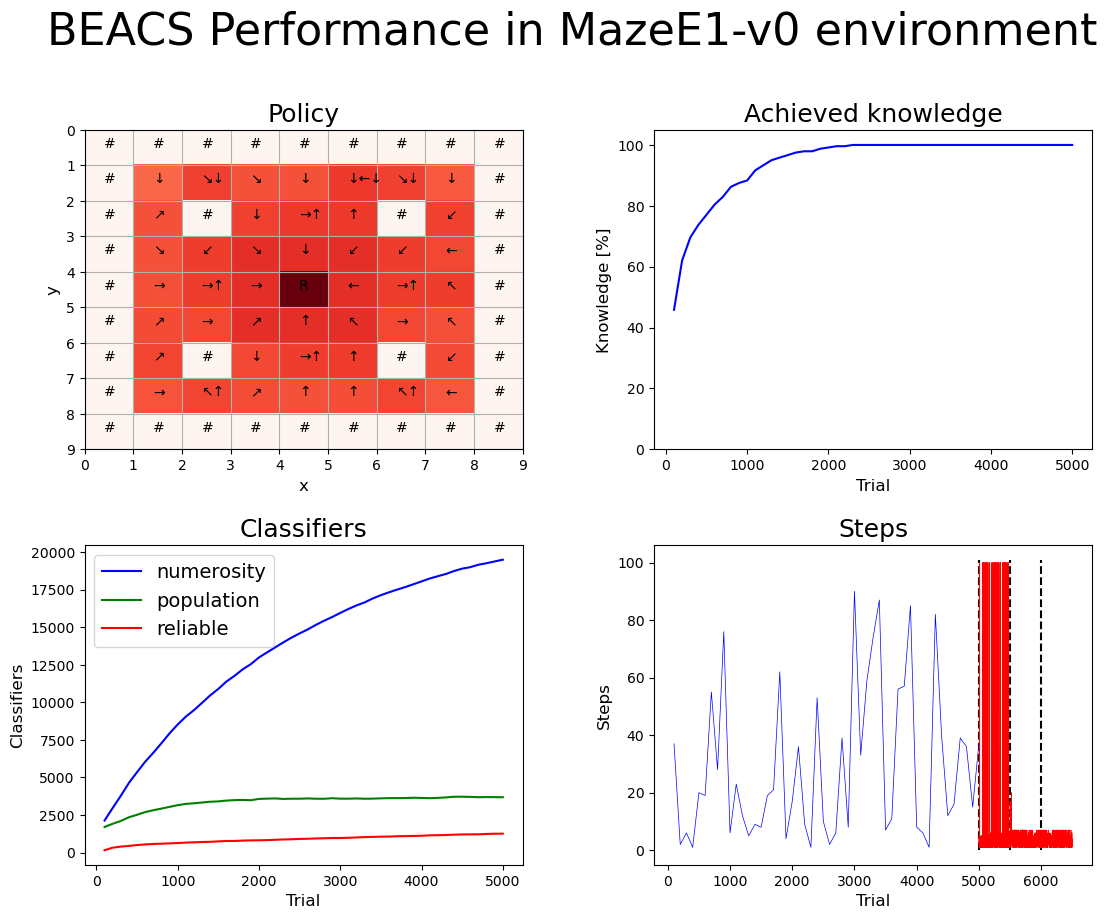

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  28.9  for a total of  5000  trials in EXPLORATION
Average number of steps to solve the maze is  10.622  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  3.612  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  3.584  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 100.0, 'population': 933, 'numerosity': 10268, 'reliable': 771}
{'knowledge': 100.0, 'population': 933, 'numerosity': 10268, 'reliable': 771}
{'knowledge': 100.0, 'population': 933, 'numerosity': 10268, 'reliable': 771}
{'knowledge': 100.0, 'population': 933, 'numerosity': 10268, 'reliable': 771}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.q)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl
    if (cl.behavioral_sequence)]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")

509


1#011100 7 [0] (0###00#9:#367, 0###0#11:#293) (10011100)
q: 1.0    ra: 880.8  rb: 908.5  ir: 0.0    f: 894.6  err: 62.69 
exp: 660   num: 12 ee: True PAI_state: 00100000
tga: 162161 tbseq: 11599 talp: 162161 tav: 203.9  



00000#00 2 [6, 1] (11#1###1:#18, ###1###9:#23, ###9###1:#22, #111###1:#14) (empty)
q: 1.0    ra: 826.8  rb: 838.7  ir: 0.0    f: 826.8  err: 108.0 
exp: 49    num: 20 ee: False PAI_state: 00100000
tga: 161330 tbseq: 138927 talp: 161330 tav: 552.0  



00000000 0 [5, 4] (###111#1:#22, ###9###1:#26, ###1#111:#28, ###1###9:#11) (empty)
q: 1.0    ra: 756.9  rb: 781.9  ir: 0.0    f: 756.9  err: 129.3 
exp: 65    num: 20 ee: False PAI_state: 00000010
tga: 160659 tbseq: 74013 talp: 160659 tav: 2.534e+03 



00000000 6 [4] (###111#1:#24, ###9###1:#26, ###1###9:#17, ###1#111:#31) (empty)
q: 1.0    ra: 745.2  rb: 764.2  ir: 0.0    f: 754.7  err: 125.5 
exp: 85    num: 20 ee: False PAI_state: 00000010
tga: 157224 tbseq: 33146 talp: 157224 tav: 2.71e+03 



00000000 0 [5]

00000111 3 [3, 4] (###11#0#:#1) (00000111)
q: 0.9685 ra: 433.5  rb: 476.9  ir: 0.0    f: 419.8  err: 364.3 
exp: 43    num: 16 ee: True PAI_state: 00000010
tga: 159836 tbseq: 47310 talp: 159836 tav: 3.476e+03 



10##0### 4 [2, 0] (0##9###1:#11, 0111###1:#32) (empty)
q: 0.9678 ra: 589.4  rb: 629.4  ir: 0.0    f: 570.4  err: 332.6 
exp: 42    num: 10 ee: False PAI_state: 00000000
tga: 159452 tbseq: 98978 talp: 159452 tav: 1.486e+03 



00#11##0 0 [0] (9##000##:#1) (empty)
q: 0.967  ra: 591.8  rb: 657.5  ir: 0.0    f: 604.0  err: 428.8 
exp: 47    num: 9 ee: False PAI_state: 00000000
tga: 160952 tbseq: 12563 talp: 160952 tav: 3.537e+03 



##9#0### 5 [2] (#90##1##:#1) (empty)
q: 0.967  ra: 617.1  rb: 543.1  ir: 0.0    f: 561.0  err: 461.6 
exp: 40    num: 20 ee: False PAI_state: 00001000
tga: 159235 tbseq: 5597  talp: 159235 tav: 4.082e+03 



#######9 1 [0] (1##0###0:#1) (empty)
q: 0.967  ra: 595.7  rb: 514.5  ir: 0.0    f: 536.8  err: 376.8 
exp: 50    num: 20 ee: False PAI_state: 0000